In [1]:
# General Imports
import pandas as pd
import seaborn as sns
from sklearn import tree
from math import ceil
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, accuracy_score, 
                             make_scorer, recall_score, f1_score, precision_score)
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
import os
from analysis_training.preprocessing_utils import drop_features_, fill_nan_values
import analysis_training


### The code reads a compressed CSV dataset from a specified file path using pandas. It focuses on preparing the dataset for classification tasks by setting the target variable, removing irrelevant features and providing key insights such as the dataset's shape, information and the count of NULL & unique values per column.
***Tasks***: 
- Reads a compressed CSV dataset using pandas.
- Defines the target variable for either multi-class or binary classification.
- Removes irrelevant features from the dataset.
- Prints the original shape of the dataset.
- Displays dataset information, including data types.
- Prints the number of NULL values per column.
- Prints the number of unique values per column.

In [2]:
# dataset_fpath = '../../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = analysis_training.load_dataset()

# Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of Dataset: {nidd_dataset.shape}")

print(f'\nDataset Information:')
nidd_dataset.info()

# print(f'\nDataset Description:')
# print(nidd_dataset.describe())

print(f'\nNumber of NULL values per column:')
print(nidd_dataset.isnull().sum())

print(f'\nNumber of unique values per column:')
print(nidd_dataset.nunique())

Original shape of Dataset: (1215890, 106)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Columns: 106 entries, SrcId to Label
dtypes: float64(66), int64(24), object(16)
memory usage: 983.3+ MB

Number of NULL values per column:
SrcId             0
Rank              0
StartTime         0
LastTime          0
Trans             0
              ...  
TcpRtt            0
SynAck            0
AckDat            0
TcpOpt       938654
Label             0
Length: 106, dtype: int64

Number of unique values per column:
SrcId             1
Rank         467717
StartTime     32888
LastTime      32828
Trans             1
              ...  
TcpRtt        18745
SynAck         3896
AckDat        23870
TcpOpt            7
Label             2
Length: 106, dtype: int64


### Dropping columns based on specified threshold values
***Tasks***:
- Initializes dictionaries to store dropped features and processing time.
- Drops columns with more than 95% NaN values from the dataset.
- Drops columns with more than 95% zero values from the updated dataset.
- Drops constant columns from the further cleaned dataset.
- Calculates and prints the time taken for the dropping features step.

In [3]:
# Dictionary to store dropped features based on different criteria
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}

# Dictionary to store processing time
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Time <Filling NaNs>": 0.,
                   "Time <Normalizing numeric features & Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.,
                   "Time <Model training>": 0.,
                   "Time <Model testing>": 0.,
                   "Time <Cross validation>": 0.,}

# Record the starting time for dropping features based on "bad" values
t0 = time()

# Dropping columns with more than 95% NaN values
threshold_nans = 0.95 * nidd_dataset.shape[0]
columns_Nan_to_drop = nidd_dataset.columns[nidd_dataset.isna().sum() > threshold_nans]
features_dropped["Nan columns"].extend(columns_Nan_to_drop)
nidd_dataset_cleaned_nan = nidd_dataset.drop(columns=columns_Nan_to_drop)
# Alternatively, you can use:
# nidd_dataset_cleaned_nan = nidd_dataset.dropna(thresh=ceil(1 - threshold_nans), axis=1)
print(f"After dropping NaN columns: {nidd_dataset_cleaned_nan.shape}")

# Dropping columns with more than 95% zero values
threshold_zeros = 0.95 * nidd_dataset.shape[0]
zero_counts = nidd_dataset_cleaned_nan.apply(lambda col: (col == 0).sum())
columns_zeros_to_drop = zero_counts[zero_counts > threshold_zeros].index
features_dropped["Zero columns"].extend(columns_zeros_to_drop)
nidd_dataset_cleaned_zeros = nidd_dataset_cleaned_nan.drop(columns_zeros_to_drop, axis=1)
print(f"After dropping NaN & Zero columns: {nidd_dataset_cleaned_zeros.shape}")

# Dropping constant columns
constant_columns = nidd_dataset_cleaned_zeros.columns[nidd_dataset_cleaned_zeros.nunique() == 1]
features_dropped["Constant columns"].extend(constant_columns)
nidd_dataset_cleaned = nidd_dataset_cleaned_zeros.drop(columns=constant_columns)
print(f"After dropping NaN & Zero & Constant columns: {nidd_dataset_cleaned.shape}")

# Record the ending time for dropping features based on "bad" values
t1 = time()

# Calculate and print the time taken for the dropping features step
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = t1 - t0
print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

# equivalent
# nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
# preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time
# print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)
Time <Dropping features based on a threshold `bad` values>: 2.559 seconds


### Filling NaN values, Z-Normalizing numeric columns using Standard Scaler and Encoding categorical columns using Label Encoder
***Tasks***:

**1. Filling NaN Values:**
   - Identify numeric and categorical columns in the cleaned dataset.
   - Fill NaN values in numeric columns with the mean of each column.
   - Fill NaN values in categorical columns with the mode of each column.
   - Print the time taken for filling NaN values.

**2. Z-Normalizing Numerical Features & Encoding Categorical Features:**
   - Use StandardScaler to normalize numeric columns.
   - Use LabelEncoder to transform categorical columns into numeric representations.
   - Print the time taken for normalizing numeric features & encoding categorical features.

In [4]:
# Record the starting time for filling NaN values
t0 = time()

# Get numeric and categorical columns
numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

# Fill NaN values in numeric columns with mean
numeric_cols_mean = nidd_dataset_cleaned[numeric_cols].mean()
nidd_dataset_cleaned[numeric_cols] = nidd_dataset_cleaned[numeric_cols].fillna(numeric_cols_mean)

# Fill NaN values in categorical columns with mode
# iloc[0] is used to get the first element of the series in case there is more than one mode.
categorical_cols_mode = nidd_dataset_cleaned[categorical_cols].mode().iloc[0]
nidd_dataset_cleaned[categorical_cols] = nidd_dataset_cleaned[categorical_cols].fillna(categorical_cols_mode)

# Record the ending time for filling NaN values
t1 = time()
preprocessing_d["Time <Filling NaNs>"] = t1 - t0

# Print the time taken for filling NaN values
print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# equivalent
# nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
# preprocessing_d["Filling NaNs"] = fill_time
# print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# Record the starting time for encoding categorical features
t0 = time()

# Z-Normalize numerical columns using StandardScaler
standard_scaler = StandardScaler()
for column in numeric_cols:
    nidd_dataset_cleaned[column] = standard_scaler.fit_transform(nidd_dataset_cleaned[[column]])

# Encoding categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

# Record the ending time for normalizing numeric columns & encoding categorical features
t1 = time()
preprocessing_d["Time <Normalizing numeric features & Encoding categorical features>"] = t1 - t0

# Print the time taken for encoding normalizing numeric columns & categorical features
print(f"Time <Normalizing numeric features & Encoding categorical features>: {preprocessing_d['Time <Normalizing numeric features & Encoding categorical features>']:.3f} seconds")

Time <Filling NaNs>: 3.475 seconds
Time <Normalizing numeric features & Encoding categorical features>: 2.631 seconds


### Using PCA for Feature Selection

After cleaning the data, the next step is to select the most relevant features for predicting the target variable. This can be done using techniques like Principal Component Analysis (PCA).


Time <Feature selection>: 6.503 seconds


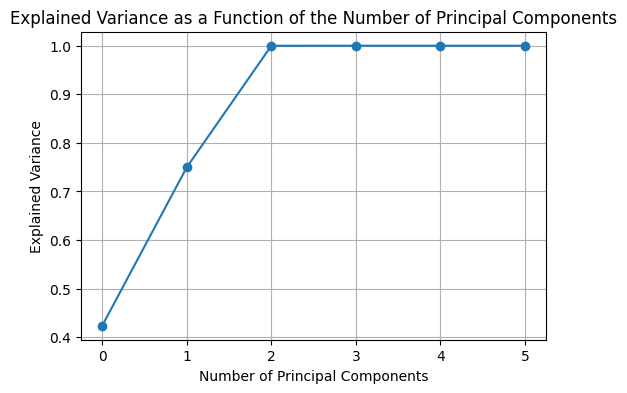

In [5]:
# Define the target variable and features
target = nidd_dataset[TARGET]
features = nidd_dataset_cleaned.iloc[:, :-1]

# Specify the number of principal components to retain
num_principal_comp = 6

# Initialize the PCA (Principal Component Analysis) object with the specified number of components
pca = PCA(n_components=num_principal_comp)

# Record the start time for measuring the processing time
t0 = time()

# Transform the features using PCA
features_pca = pca.fit_transform(features)

# Record the end time after the transformation
t1 = time()

# Calculate and store the processing time for feature selection
preprocessing_d['Time <Feature selection>'] = t1 - t0

# Print the time taken for feature selection using PCA
print(f"\nTime <Feature selection>: {preprocessing_d['Time <Feature selection>']:.3f} seconds")

# Create a DataFrame with the transformed features, naming the columns as PC1, PC2, ..., PCn
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(num_principal_comp)])

# Obtain the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative variance explained by the principal components
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative variance explained as a function of the number of principal components
plt.figure(figsize=(6, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance as a Function of the Number of Principal Components')
plt.grid(True)
plt.show()

### Random Forest Classifier Training and Testing

Training and testing of the Decision Tree Classifier using Principal Component Analysis (PCA) for feature selection.

**Data Splitting**
The dataset (`df_pca`) is split into training and testing sets using the `train_test_split` function with a test size of 30% and a random state of 42.

**Model Initialization**
A Decision Tree Classifier (`DTClassifier`) is initialized with a fixed random state for reproducibility.

**Model Training**
The time taken for training the Random Forest model is measured using the `time` module. The training data (`X_train`, `y_train`) is then used to fit the model.

**Model Testing**
Similarly, the time taken for testing the model is measured. The testing data (`X_test`) is used to make predictions, and the time taken is recorded.

The elapsed times for both training and testing are printed for evaluation.

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_pca, target, test_size=0.3, random_state=rnd.seed(42))

# Initialize a Decision Tree Classifier
DTClassifier = DecisionTreeClassifier(random_state=42)

# Measure the time taken for model training
t0 = time()
DTClassifier.fit(X_train, y_train)
t1 = time()
preprocessing_d["Time <Model training>"] = t1 - t0

# Print the time taken for training the model
print(f"Time <Model training>: {preprocessing_d['Time <Model training>']:.3f} seconds")

# Measure the time taken for model testing
t0 = time()
predictions = DTClassifier.predict(X_test)
t1 = time()
preprocessing_d["Time <Model testing>"] = t1 - t0

# Print the time taken for testing the model
print(f"Time <Model testing>: {preprocessing_d['Time <Model testing>']:.3f} seconds")


Time <Model training>: 13.567 seconds
Time <Model testing>: 0.033 seconds


### Confusion Matrix and Classification Report
***Tasks***:
- Calculate the confusion matrix using the predicted and true labels from the test data.
- Plot the confusion matrix using a heatmap for better visualization.
   - Each cell represents the count of true positive instances, with text annotations.
- Generate and print the classification report, including precision, recall and F1-score for each class in the target variable.

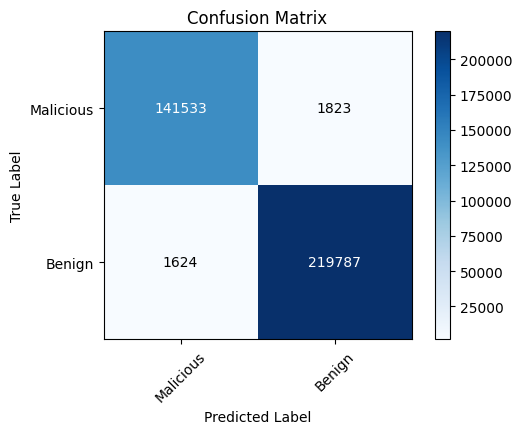

Classification Report:
               precision    recall  f1-score   support

   Malicious   0.987283  0.988656  0.987969    143157
      Benign   0.992665  0.991774  0.992219    221610

    accuracy                       0.990550    364767
   macro avg   0.989974  0.990215  0.990094    364767
weighted avg   0.990553  0.990550  0.990551    364767



In [7]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Get the unique categories in the target variable
target_categories = set(nidd_dataset[TARGET])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Generate and print the classification report
class_report = classification_report(predictions, y_test, target_names=target_categories, digits=6)
print("Classification Report:\n", class_report)

### Feature Importance Analysis and Decision Tree Visualization
***Tasks***:
- Extract feature importances from the trained model.
- Create a DataFrame to store feature names and their corresponding importances, sorted in descending order.
- Print the feature importances.
- Plot a bar chart for visualizing feature importances.

Feature Importances:
  Feature  Importance
5     PC6    0.377662
4     PC5    0.216415
1     PC2    0.186972
3     PC4    0.107265
0     PC1    0.060050
2     PC3    0.051637


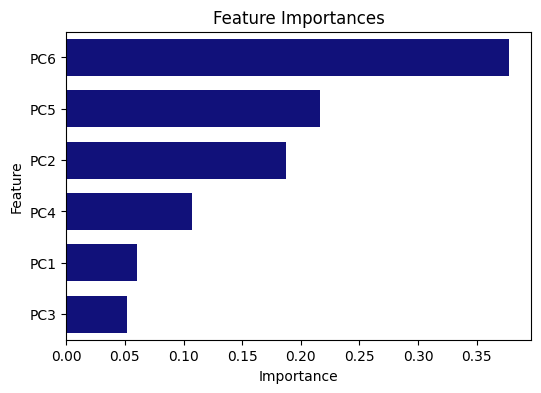

In [8]:
# Extract feature importances from the trained model
data = list(zip([f'PC{i+1}' for i in range(num_principal_comp)], DTClassifier.feature_importances_))
rf_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(rf_importances)

# Plot a bar chart for visualizing feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', 
            data=rf_importances,
            width=1.2, gap=0.4,
            color='#00008B')
plt.title('Feature Importances')
plt.show()


# Uncomment the following lines if you want to visualize the corresponding decision tree of Random Forest Classifier
# fn = X_test.columns
# cn = pipeline['classifier'].classes_
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
# tree.plot_tree(rf.estimators_[0],
#                feature_names=fn,
#                class_names=cn,
#                filled=True)
# fig.savefig('rf_tree.png')

### K-Fold Cross Validation for Model Evaluation
***Tasks***:
- Specify the number of folds for cross-validation (e.g. cv = 5).
- Define the scoring metrics for evaluation, including F1 score, Accuracy, Recall and Precision.
- Create a RandomForestClassifier.
- Measure the time taken for cross-validation using the specified metrics.

In [9]:
# Number of folds for cross-validation
cv = 5

# Define the scoring metrics for evaluation
scoring = {'F1': make_scorer(f1_score, pos_label='Benign'), 
           'Accuracy': make_scorer(accuracy_score), 
           'Recall': make_scorer(recall_score, pos_label='Benign'),
           'Precision': make_scorer(precision_score, pos_label='Benign')}


# Measure the time taken for cross-validation
t0 = time()
scores = cross_validate(DecisionTreeClassifier(random_state=rnd.seed(42)), df_pca, nidd_dataset[TARGET], 
                        cv=cv, scoring=scoring, return_train_score=True)
t1 = time()
preprocessing_d["Time <Cross validation>"] = t1 - t0

# Print the time taken for cross-validation
print(f"\nTime <Cross validation>: {preprocessing_d['Time <Cross validation>']:.3f} seconds")


Time <Cross validation>: 170.506 seconds


### Calculates overall mean scores and visualizes individual fold scores for each metric on both the training and testing sets.
***Tasks***:
- Print overall mean scores for each metric, including F1 Score, Accuracy, Recall and Precision.
- Plot individual cross-validation fold scores for each metric on both training and testing sets.
   - The x-axis represents the fold number.
   - Different colors distinguish between training and testing scores.

Overall F1 Results:
Mean Train F1: 1.0000
Mean Test F1: 0.8334
Overall Accuracy Results:
Mean Train Accuracy: 1.0000
Mean Test Accuracy: 0.8676
Overall Recall Results:
Mean Train Recall: 1.0000
Mean Test Recall: 0.8820
Overall Precision Results:
Mean Train Precision: 1.0000
Mean Test Precision: 0.8121


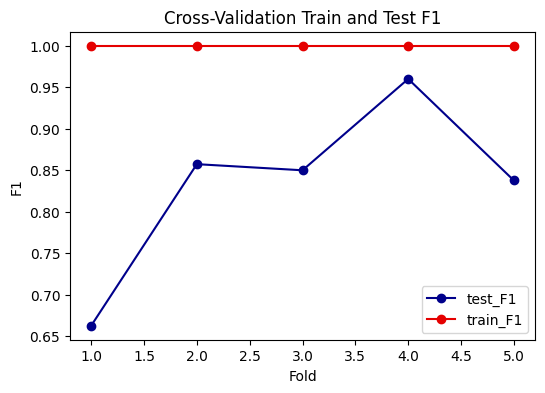

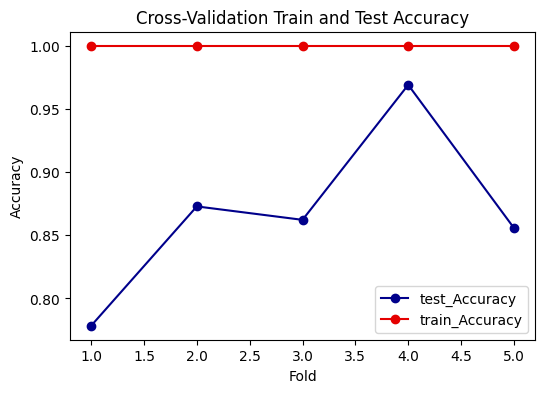

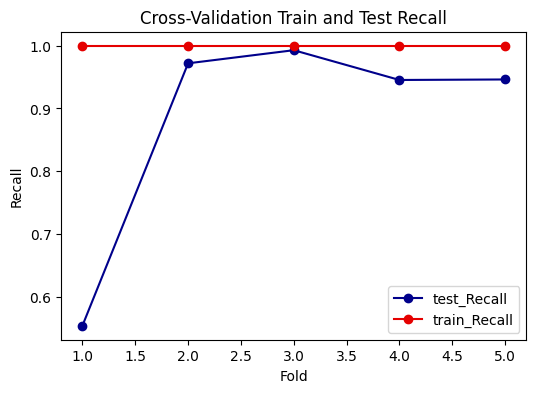

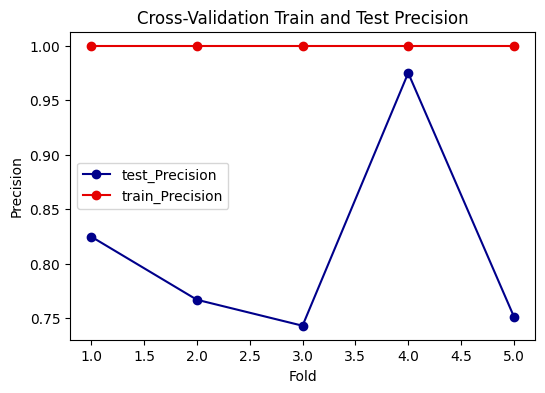

In [10]:
# Print overall mean scores for each metric
for metric in scoring.keys():
    mean_train_score = np.mean(scores[f'train_{metric}'])
    mean_test_score = np.mean(scores[f'test_{metric}'])
    print(f"Overall {metric} Results:")
    print(f"Mean Train {metric}: {mean_train_score:.4f}")
    print(f"Mean Test {metric}: {mean_test_score:.4f}")
    print("======================")

# Plot individual cross-validation fold scores for each metric
for metric in scoring.keys():
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, cv+1), scores[f'test_{metric}'], label=f'test_{metric}', marker='o', color='#00008B')
    plt.plot(range(1, cv+1), scores[f'train_{metric}'], label=f'train_{metric}', marker='o', color='#E50000')
    plt.title(f'Cross-Validation Train and Test {metric}')
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

### Visualize the comparison to assess the model's consistency across cross-validation folds.

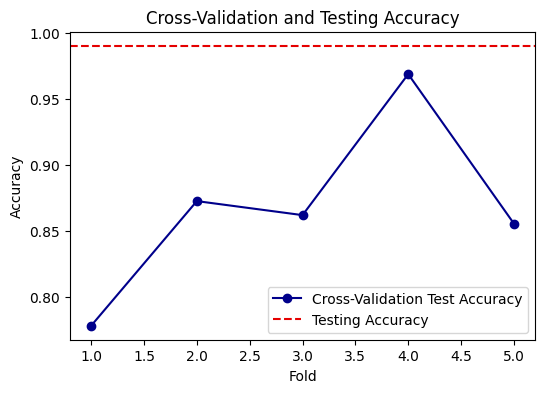

In [11]:
# Plot cross-validation test accuracy and a reference line for the testing accuracy of the model
plt.figure(figsize=(6, 4))
plt.plot(range(1, cv+1), scores[f'test_Accuracy'], label='Cross-Validation Test Accuracy', marker='o', color='#00008B')
plt.axhline(accuracy_score(y_test, predictions), linestyle='--', label='Testing Accuracy', color='#E50000')
plt.title('Cross-Validation and Testing Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Processing times for various preprocessing steps involved in the data preparation and model training pipeline

In [12]:
# Print the preprocessing times
print("Time Report:")
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")

Time Report:
Time <Dropping features based on a threshold `bad` values>: 2.5594 seconds
Time <Filling NaNs>: 3.4754 seconds
Time <Normalizing numeric features & Encoding categorical features>: 2.6307 seconds
Time <Feature selection>: 6.5025 seconds
Time <Model training>: 13.5670 seconds
Time <Model testing>: 0.0332 seconds
Time <Cross validation>: 170.5062 seconds
